In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import experimental, Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


2024-02-01 16:50:33.150411: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 16:50:35.302664: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 16:50:40.505929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 16:50:40.505978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 16:50:41.163861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [18]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
	"../leaves/images/", 
	shuffle = True, 
	image_size = (IMAGE_SIZE, IMAGE_SIZE), 
	batch_size = BATCH_SIZE
)

Found 7227 files belonging to 8 classes.


In [4]:
im = Image.open("../leaves/images/Apple_Black_rot/image (1).JPG", "r")
imArray = np.array(im)

In [5]:
imArray.shape

(256, 256, 3)

In [6]:
class_names = dataset.class_names
len(class_names)

8

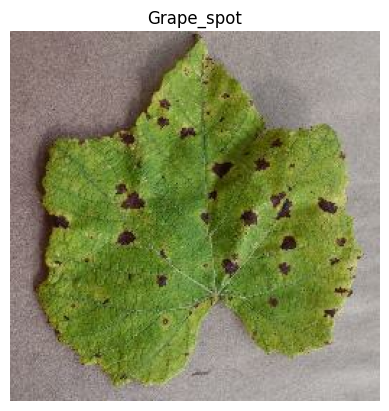

In [7]:
for image_batch, label_batch in dataset.take(1):
	plt.imshow(image_batch[0].numpy().astype("uint8"))
	plt.title(class_names[label_batch[0]])
	plt.axis("off")

In [8]:
len(dataset)

226

In [9]:
def get_dataset_partition_tf(ds, train_split = 0.8, cv_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
	if shuffle:
		ds = ds.shuffle(shuffle_size, seed = 12)
	
	len_train_dataset = int(len(ds) * train_split)
	len_cv = int(len(ds) * cv_split)
	train_dataset = ds.take(len_train_dataset)
	cv_dataset = ds.skip(len_train_dataset).take(len_cv)
	test_dataset = ds.skip(len_train_dataset + len_cv)
	return train_dataset, cv_dataset, test_dataset

In [10]:
train_ds, cv_ds, test_ds = get_dataset_partition_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
cv_ds = cv_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = Sequential([
	experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
	experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = Sequential([
	experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
	experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = Sequential([
	resize_and_rescale, 
	data_augmentation, 
	Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
	MaxPooling2D((2,2)),

	Conv2D(32, (3,3),  activation = 'relu'),
	MaxPooling2D((2,2)),

	Flatten(),
	Dense(64, activation = 'relu'), 
	Dense(len(class_names), activation = 'softmax')
])

In [15]:
model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [16]:
model.compile(
	loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
	optimizer = 'adam',
	metrics = ['accuracy'])

In [19]:
history = model.fit(
	train_ds, 
	epochs = EPOCHS, 
	batch_size = BATCH_SIZE, 
	verbose = 1, 
	validation_data = cv_ds
)

Epoch 1/10
180/180 [==============================] - 105s 584ms/step - loss: 0.5689 - accuracy: 0.7948 - val_loss: 0.6149 - val_accuracy: 0.7969
Epoch 2/10
180/180 [==============================] - 109s 602ms/step - loss: 0.4771 - accuracy: 0.8341 - val_loss: 0.6199 - val_accuracy: 0.8054
Epoch 3/10
180/180 [==============================] - 104s 578ms/step - loss: 0.3912 - accuracy: 0.8619 - val_loss: 1.1765 - val_accuracy: 0.7188
Epoch 4/10
180/180 [==============================] - 103s 573ms/step - loss: 0.3396 - accuracy: 0.8761 - val_loss: 0.9442 - val_accuracy: 0.7486
Epoch 5/10
180/180 [==============================] - 102s 565ms/step - loss: 0.3029 - accuracy: 0.8898 - val_loss: 0.5973 - val_accuracy: 0.8068
Epoch 6/10
180/180 [==============================] - 102s 565ms/step - loss: 0.2784 - accuracy: 0.9046 - val_loss: 0.3285 - val_accuracy: 0.8849
Epoch 7/10
180/180 [==============================] - 101s 563ms/step - loss: 0.2346 - accuracy: 0.9149 - val_loss: 0.4330 -

(-0.5, 255.5, 255.5, -0.5)

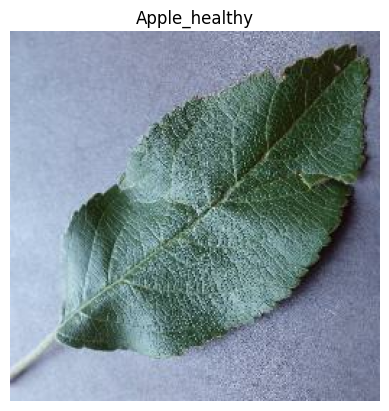

In [82]:
for image_batch, label_batch in dataset.take(1):
	image_to_test = image_batch[0].numpy().astype("uint8")
	label_image_to_test = label_batch[0]

plt.imshow(image_to_test)
plt.title(class_names[label_image_to_test])
plt.axis("off")

In [83]:
y_pred = model.predict(image_to_test.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3))
predicted_class = np.argmax(y_pred)
print("Prediction :",class_names[predicted_class])

1/1 [==============================] - 0s 14ms/step
Prediction : Apple_healthy


In [56]:
# Sauvegarder le modèle
model.save('mon_cnn_model.keras')

# Visualisation des calques intermediaires

1/1 [==============================] - 1s 563ms/step


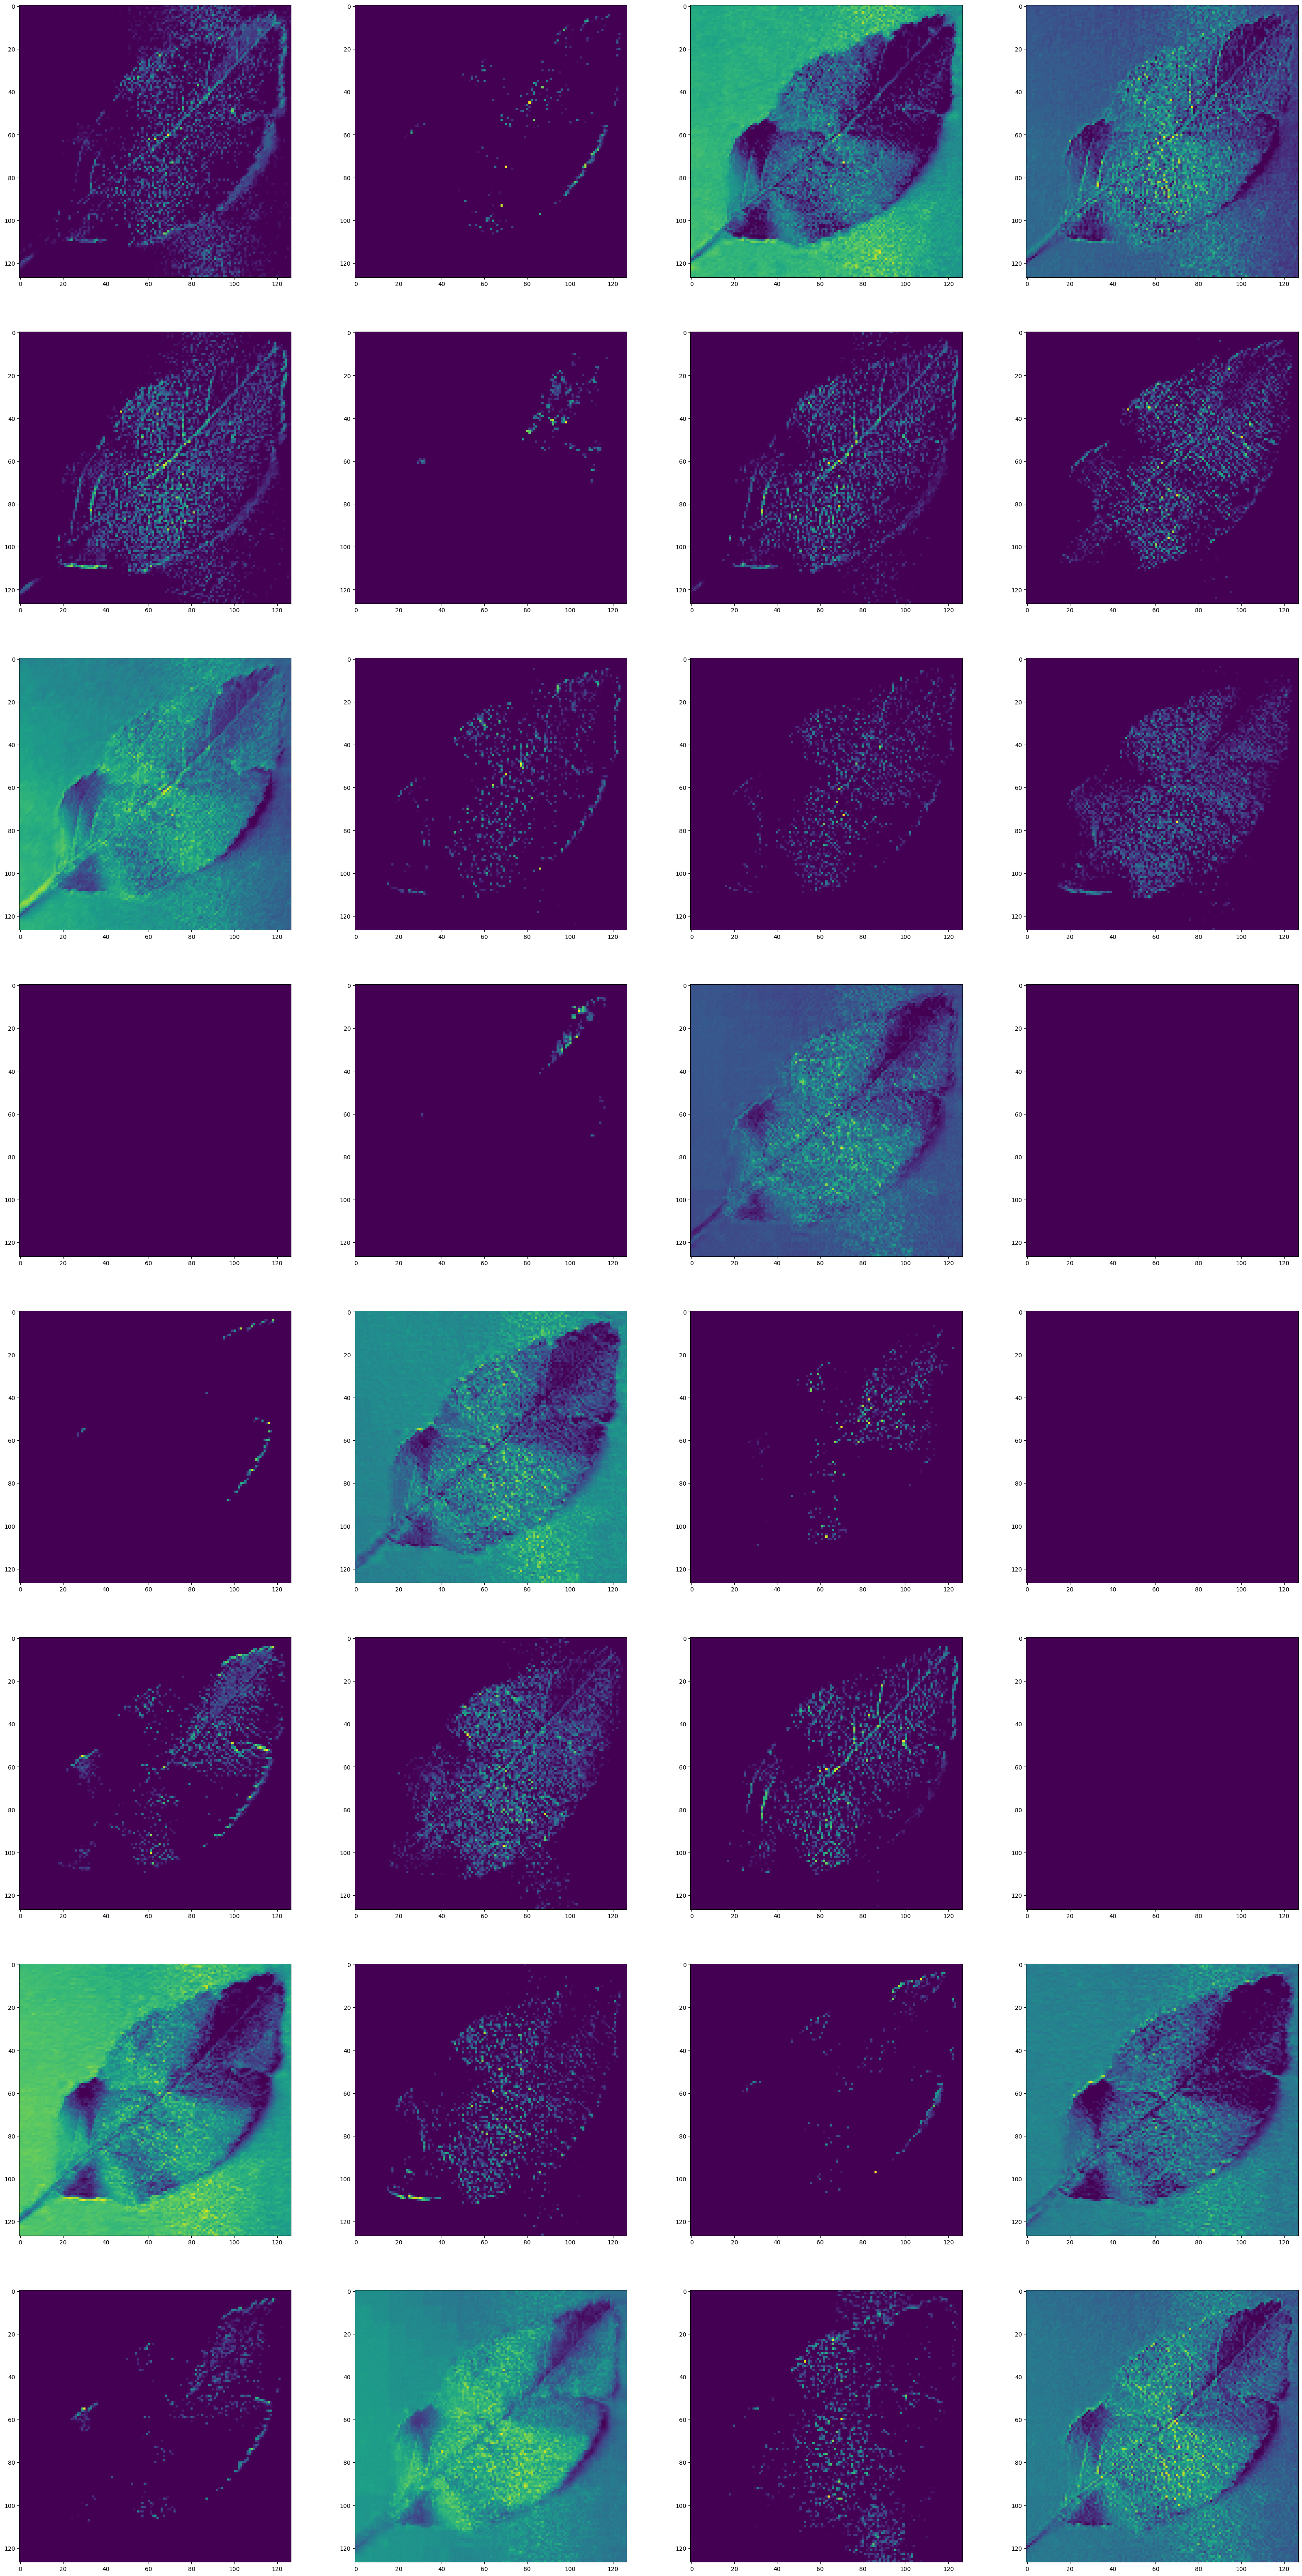

In [90]:
# Création d'un nouveau modèle qui prend la même entrée que le modèle d'origine, mais renvoie les sorties du premier filtre Conv2D
activation_model = Model(inputs=model.input, outputs=model.layers[3].output)
image_to_test_bis = image_to_test.reshape((1,) + image_to_test.shape)


# Obtenez les activations du premier filtre Conv2D pour l'exemple donné
activations = activation_model.predict(image_to_test_bis)

nb_col_graph = 4
nb_lignes_graph = 8
plt.figure(figsize=(nb_col_graph * 10, nb_lignes_graph * 10))
for i in range(32):
    plt.subplot(nb_lignes_graph, nb_col_graph, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')  # Vous pouvez changer 'viridis' par une autre colormap
plt.show()